# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1OS9WLVhAHEmDyzb6JzevXgiTTJ60sGtM?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:05<00:00, 33585071.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

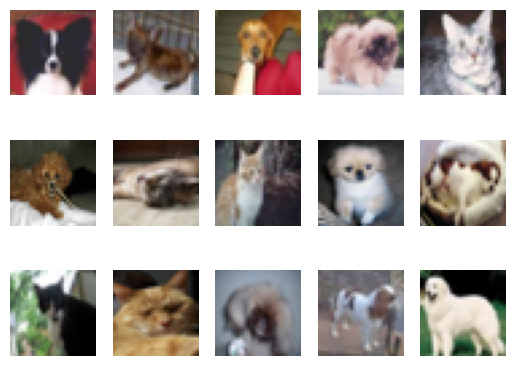

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
distinct = set()
for images,labels in train_loader:
  distinct.add(tuple(labels.tolist()))
print(distinct)
# We only have cat and dog classes

print(f"Training Examples: {len(train_loader)}")
print(f"Validation Examples: {len(val_loader)}")
print(f"Test Examples: {len(test_loader)}")

{(3,), (5,)}
Training Examples: 8000
Validation Examples: 2000
Test Examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
#We need validation set because using training set to judge the performance of our models cannot indicate
#if the models generalize well to unseen data or not. If we use training set to evaluate
#the models' performance, the most complex model will always be selected,
#as it fits to all the data, including noises, giving low training error.
#However, if we use validation error, the best model to generalize to unseen data will be selected, which is what we care about.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)
#386 for SmallNet, including bias terms
#9705 for LargeNet, including bias terms

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [ ]:
for param in large_net.parameters():
  print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [ ]:
#64, 0.01, 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
#train_net(small_net, num_epochs=5)
#model_small_bs64_lr0.01_epoch0 => model's parameters for the first epoch
#model_small_bs64_lr0.01_epoch1 => model's parameters for the second epoch
#model_small_bs64_lr0.01_epoch2 => model's parameters for the third epoch
#model_small_bs64_lr0.01_epoch3 => model's parameters for the forth epoch
#model_small_bs64_lr0.01_epoch4 => model's parameters for the fifth epoch
#model_small_bs64_lr0.01_epoch4_train_err => mean training error for every epoch, total incorrect prediction/ total prediction,
#calculated while training in each epoch
#model_small_bs64_lr0.01_epoch4_train_loss => mean binary cross-entropy (BCE) error for every epoch based on the training data,
#calculated while training in each epoch
#model_small_bs64_lr0.01_epoch4_val_err => mean validation error for every epoch, total incorrect prediction / total prediction,
#calculated after training of each epoch
#model_small_bs64_lr0.01_epoch4_val_loss => mean binary cross-entropy (BCE) error for every epoch based on the validation data,
#calculated after training of each epoch

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.414375, Train loss: 0.6717066459655762 |Validation err: 0.382, Validation loss: 0.6557652298361063
Epoch 2: Train err: 0.3635, Train loss: 0.6459677453041077 |Validation err: 0.3835, Validation loss: 0.6642969120293856
Epoch 3: Train err: 0.349125, Train loss: 0.6306136822700501 |Validation err: 0.34, Validation loss: 0.6221622209995985
Epoch 4: Train err: 0.331125, Train loss: 0.6123361911773681 |Validation err: 0.3445, Validation loss: 0.6182842385023832
Epoch 5: Train err: 0.32025, Train loss: 0.6032502620220185 |Validation err: 0.325, Validation loss: 0.61301582865417
Finished Training
Total time elapsed: 25.60 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.427375, Train loss: 0.6774106206893921 |Validation err: 0.378, Validation loss: 0.6593555528670549
Epoch 2: Train err: 0.365125, Train loss: 0.6447394533157349 |Validation err: 0.367, Validation loss: 0.6504110544919968
Epoch 3: Train err: 0.349625, Train loss: 0.6308710169792175 |Validation err: 0.3425, Validation loss: 0.6241882015019655
Epoch 4: Train err: 0.338, Train loss: 0.6157628531455994 |Validation err: 0.3485, Validation loss: 0.6269324030727148
Epoch 5: Train err: 0.3285, Train loss: 0.6056356673240662 |Validation err: 0.3355, Validation loss: 0.6112872939556837
Epoch 6: Train err: 0.32075, Train loss: 0.5942276575565338 |Validation err: 0.3275, Validation loss: 0.6088105775415897
Epoch 7: Train err: 0.313375, Train loss: 0.5881726610660553 |Validation err: 0.3225, Validation loss: 0.6008554734289646
Epoch 8: Train err: 0.30175, Train loss: 0.5815456295013428 |Validation err: 0

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.474, Train loss: 0.6902655873298645 |Validation err: 0.454, Validation loss: 0.6862887628376484
Epoch 2: Train err: 0.4415, Train loss: 0.6827721524238587 |Validation err: 0.4345, Validation loss: 0.6911793779581785
Epoch 3: Train err: 0.416625, Train loss: 0.6732163019180298 |Validation err: 0.3815, Validation loss: 0.6616418343037367
Epoch 4: Train err: 0.380125, Train loss: 0.6556994457244874 |Validation err: 0.3645, Validation loss: 0.6509934235364199
Epoch 5: Train err: 0.362, Train loss: 0.6422031593322753 |Validation err: 0.356, Validation loss: 0.6344756800681353
Epoch 6: Train err: 0.34525, Train loss: 0.6208089771270752 |Validation err: 0.366, Validation loss: 0.6365893315523863
Epoch 7: Train err: 0.33025, Train loss: 0.6068008756637573 |Validation err: 0.3345, Validation loss: 0.6080429144203663
Epoch 8: Train err: 0.315375, Train loss: 0.5866262481212616 |Validation err: 0.318

Large_net took longer to train because the architecture of neural network is Larger, meaning more weights and biases. This results in more computational effort in doing forward and backpropagation

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

Small


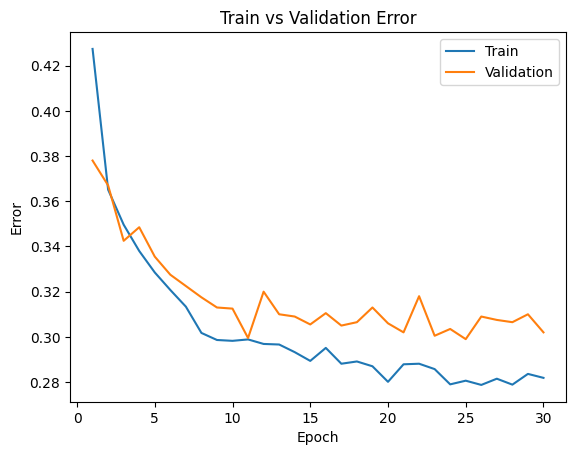

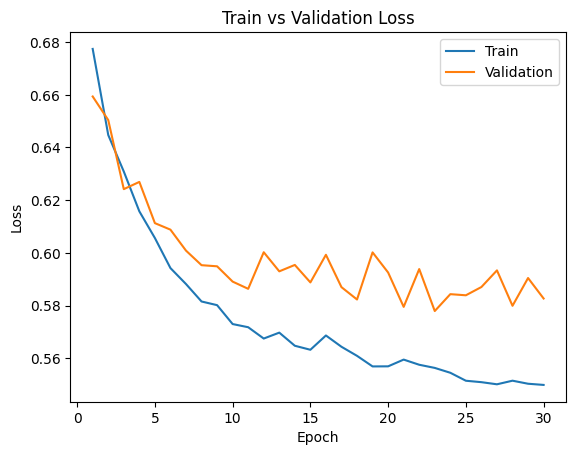

Large


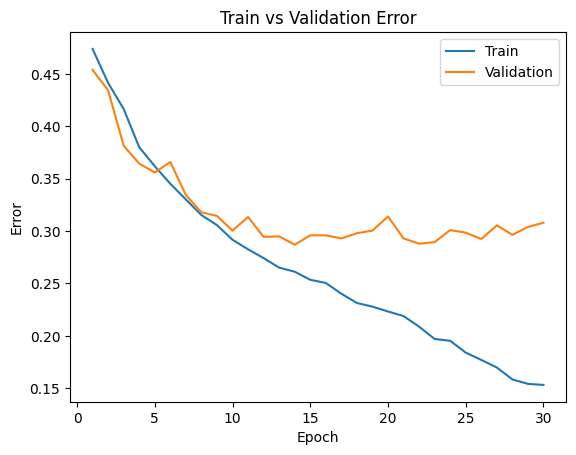

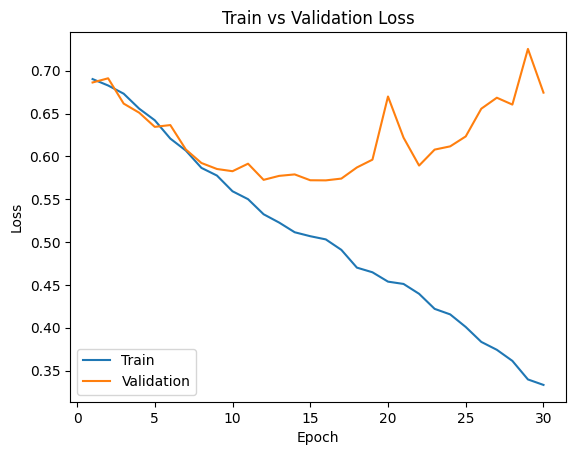

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print("Small")
plot_training_curve(small_path)
print("====================================")
print("Large")
plot_training_curve(large_path)
print("====================================")


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
#The training curve tends to decrease smoothly, while the validation curve decreases with lots of spikes.
#The train curve for small Net decrease exponentially,
#while large Net decrease almost linearly. The best performance (Lowest Validation error/ loss)
#is about the same for both models; however, Large Net
#got to the lowest validation point much faster; after that, it starts increasing indicating overfit seen
#from Large Net graphs at around epoch 15.
#Underfitting occured at the start of the graph, as the models still have insufficient training.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493494063616
Epoch 3: Train err: 0.43575, Train loss: 0.6916067256927491 |Validation err: 0.4285, Validation loss: 0.6908544301986694
Epoch 4: Train err: 0.43, Train loss: 0.6908613419532776 |Validation err: 0.424, Validation loss: 0.6896595824509859
Epoch 5: Train err: 0.434125, Train loss: 0.6899194955825806 |Validation err: 0.4195, Validation loss: 0.6886935662478209
Epoch 6: Train err: 0.43575, Train loss: 0.688741192817688 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774199485779 |Validation err: 0.4185, Validation loss: 0.6851983051747084
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.41

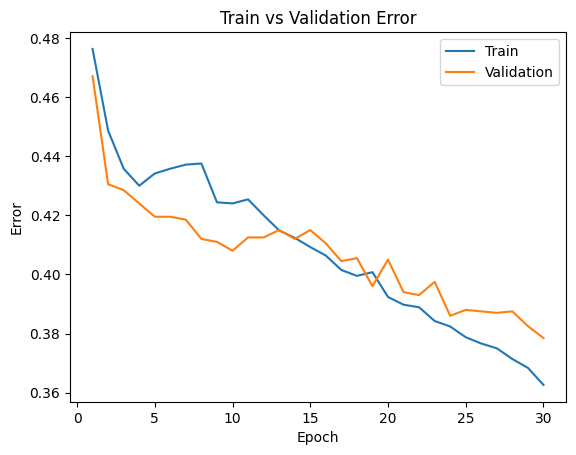

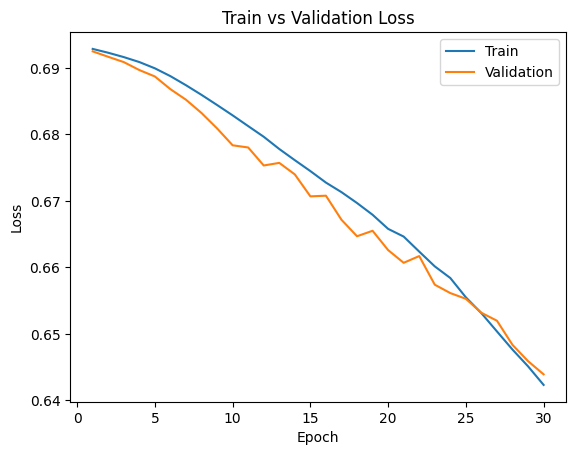

In [ ]:
large_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_path)

The model takes longer to train. The Training and Validation Error/ Loss decreases as a much slower rate. From the large Net with default parameters graphs, we can see that the large Net with small learning rate still hasn't moved enough to pass the optimal point (Lowest Validation Error).

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743778004646301 |Validation err: 0.3595, Validation loss: 0.6350856963545084
Epoch 2: Train err: 0.36075, Train loss: 0.6411805462837219 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813464164734 |Validation err: 0.3385, Validation loss: 0.6056603863835335
Epoch 4: Train err: 0.352625, Train loss: 0.623345623254776 |Validation err: 0.3575, Validation loss: 0.6362800160422921
Epoch 5: Train err: 0.34075, Train loss: 0.610801386833191 |Validation err: 0.3305, Validation loss: 0.6064918749034405
Epoch 6: Train err: 0.323375, Train loss: 0.5921835992336273 |Validation err: 0.317, Validation loss: 0.5967769687995315
Epoch 7: Train err: 0.3145, Train loss: 0.5817317562103271 |Validation err: 0.3365, Validation loss: 0.6204487904906273
Epoch 8: Train err: 0.29825, Train loss: 0.5660300071239471 |Validation err: 0.

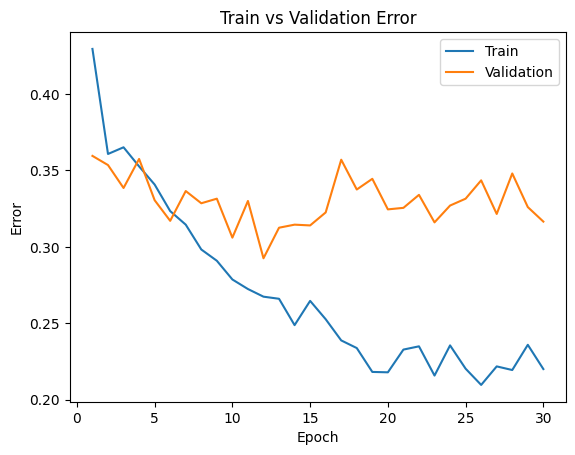

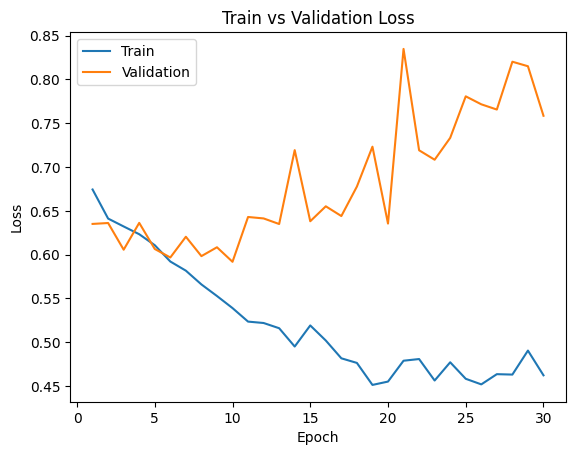

In [ ]:
large_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_path)

It takes shorter to train this model. The validation curves have lots more spikes and it becomes overfitted quicker only at around 10th epoch.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104057252407 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500627994537 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449903130531 |Validation err: 0.424, Validation loss: 0.6897870302200317
Epoch 5: Train err: 0.434, Train loss: 0.6896935515105724 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883532106876373 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871751844883 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, V

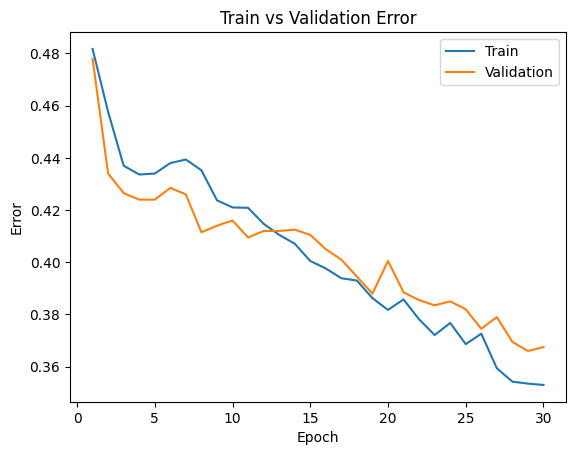

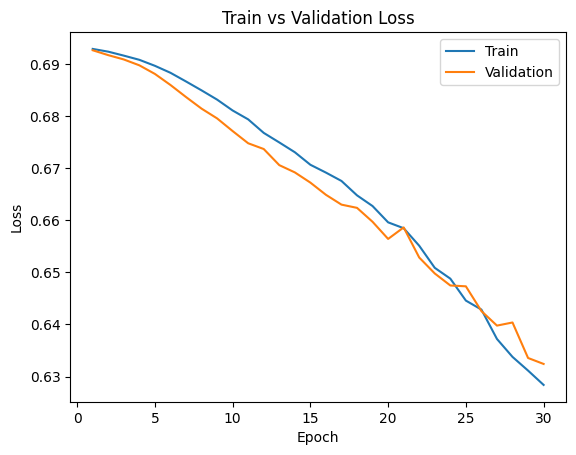

In [ ]:
large_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

It takes shorter to train compared to the default model. The graph is more smooth; however, it converges to the optimal validation point slower.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net,batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994033575058 |Validation err: 0.382, Validation loss: 0.6513170146942139
Epoch 2: Train err: 0.369, Train loss: 0.6396398993134499 |Validation err: 0.3465, Validation loss: 0.6161113579273224
Epoch 3: Train err: 0.34375, Train loss: 0.6098222960829734 |Validation err: 0.3325, Validation loss: 0.6260210766792297
Epoch 4: Train err: 0.314375, Train loss: 0.584969149172306 |Validation err: 0.34, Validation loss: 0.6044013905525207
Epoch 5: Train err: 0.301125, Train loss: 0.5689119317531586 |Validation err: 0.3125, Validation loss: 0.5769183149337769
Epoch 6: Train err: 0.281, Train loss: 0.5452213580608368 |Validation err: 0.308, Validation loss: 0.570844743013382
Epoch 7: Train err: 0.270875, Train loss: 0.5272981309890747 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.507090549826622 |Validation err: 0.313, V

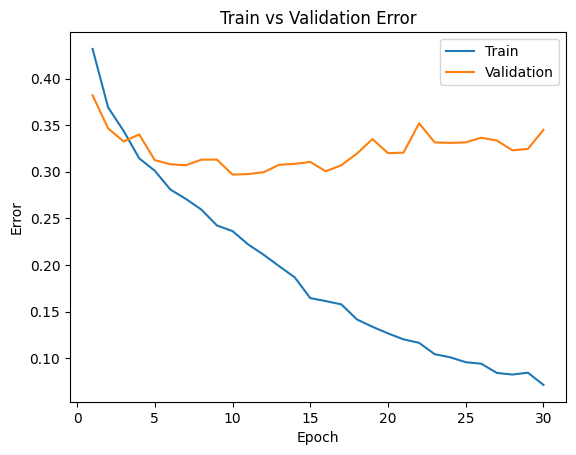

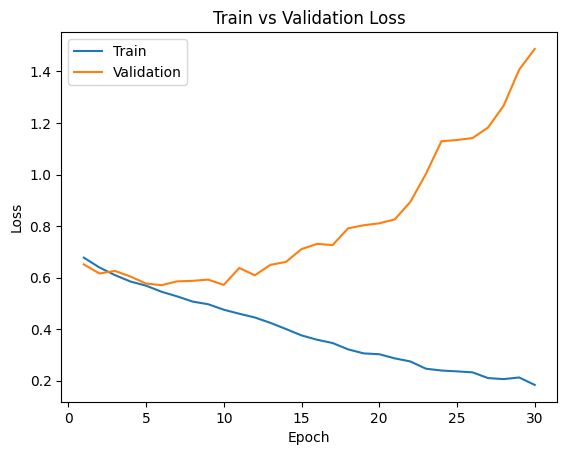

In [ ]:
large_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

The model takes longer to train compared to the default model. The model converges to the optimal validation point much faster. Therefore, it overfits much faster and the training error decrease as a faster rate.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
#(LargeNet(), 64 ,0.005) Because learning rate of 0.01 overfits very fast,
#and learning rate of 0.001 hasn't converge to the optimal validation point.

# So, I have chosen lr = 0.005 which is between 0.01 and 0.001 with the hope to
# find optimal validation point with more precision than lr = 0.01

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.005)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4525, Train loss: 0.6918498039245605 |Validation err: 0.429, Validation loss: 0.6890992540866137
Epoch 2: Train err: 0.441375, Train loss: 0.6870906562805176 |Validation err: 0.4175, Validation loss: 0.6815983355045319
Epoch 3: Train err: 0.419125, Train loss: 0.6800040378570557 |Validation err: 0.414, Validation loss: 0.6721472628414631
Epoch 4: Train err: 0.4075, Train loss: 0.6727880077362061 |Validation err: 0.4, Validation loss: 0.6650289222598076
Epoch 5: Train err: 0.393125, Train loss: 0.6650955910682679 |Validation err: 0.3895, Validation loss: 0.6580633856356144
Epoch 6: Train err: 0.375625, Train loss: 0.6546039323806763 |Validation err: 0.378, Validation loss: 0.6485581323504448
Epoch 7: Train err: 0.372375, Train loss: 0.6454356803894042 |Validation err: 0.3775, Validation loss: 0.6415849011391401
Epoch 8: Train err: 0.35675, Train loss: 0.6330658745765686 |Validation err: 0.3

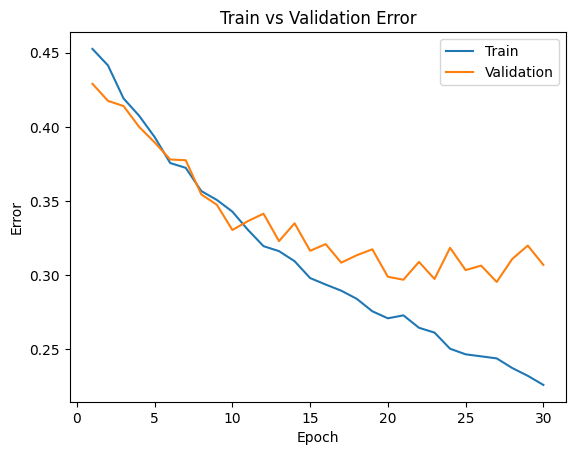

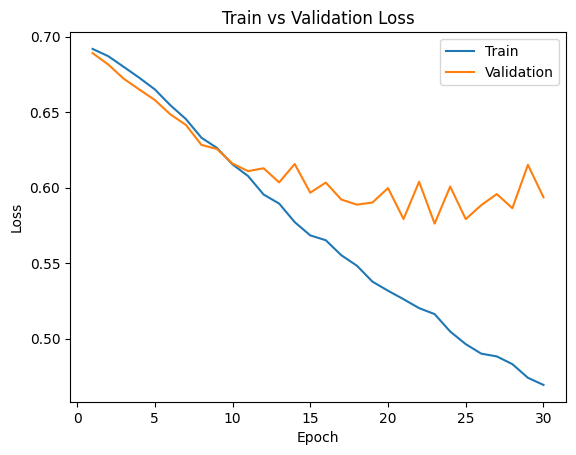

In [ ]:
large_path = get_model_name("large", batch_size=64, learning_rate=0.005, epoch=29)
plot_training_curve(large_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

In [ ]:
#(LargeNet(), 32 ,0.005) The model still hasn't shown any sign of overfit,
#meaning it still might not have passed the optimal validation point.
#Decreasing batch size will make it converges faster.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,learning_rate=0.005, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.451125, Train loss: 0.6895513634681701 |Validation err: 0.4235, Validation loss: 0.6799672132446652
Epoch 2: Train err: 0.41475, Train loss: 0.6770808389186859 |Validation err: 0.426, Validation loss: 0.6783659694686769
Epoch 3: Train err: 0.399, Train loss: 0.6652117218971253 |Validation err: 0.399, Validation loss: 0.6516326363124545
Epoch 4: Train err: 0.3785, Train loss: 0.6488407545089722 |Validation err: 0.393, Validation loss: 0.6554539099572196
Epoch 5: Train err: 0.357, Train loss: 0.630372572183609 |Validation err: 0.342, Validation loss: 0.6204922927750481
Epoch 6: Train err: 0.339, Train loss: 0.6117297103404998 |Validation err: 0.348, Validation loss: 0.6352075660039508
Epoch 7: Train err: 0.323375, Train loss: 0.5982237352132798 |Validation err: 0.3235, Validation loss: 0.6010712626434508
Epoch 8: Train err: 0.316375, Train loss: 0.5813896110057831 |Validation err: 0.3275, Va

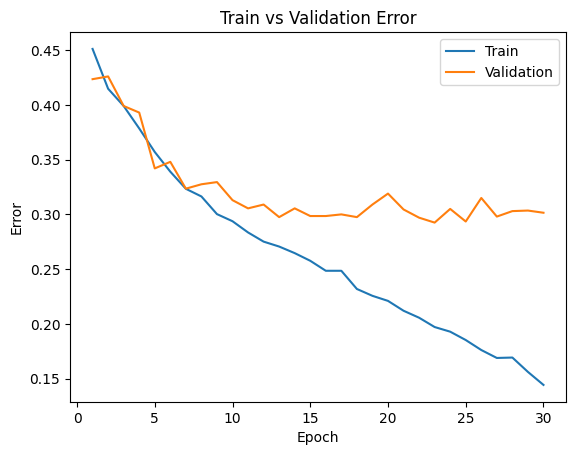

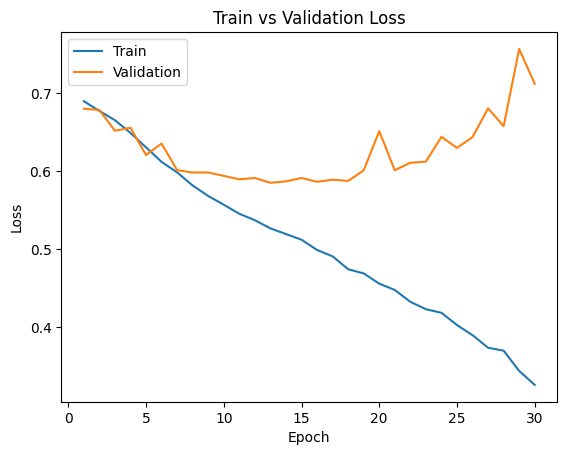

In [ ]:
large_path = get_model_name("large", batch_size=32, learning_rate=0.005, epoch=29)
plot_training_curve(large_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=11)
state = torch.load(model_path)
net.load_state_dict(state)

<ipython-input-27-97529e3b3902>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
#I will choose Epoch 12 from Original LargeNet()


### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# The lowest validation error is around 0.287
# The lowest validation loss is around 0.571
#Epoch 12: Train err: 0.27425, Train loss: 0.5324860475063324 |Validation err: 0.2945, Validation loss: 0.5726518584415317
#I have chosen this model because the validation error and loss is very close to the lowest achieved across all models.


### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, criterion)
print(f"Prediction Error: {err}, BCE Error: {loss}")

Files already downloaded and verified
Files already downloaded and verified
Prediction Error: 0.277, BCE Error: 0.5437365910038352


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
#Note: Optimistic means the evaluation metrics indicates model performance to be
#better than what the model would actually achieve when facing unseen data.

In [ ]:
#Test classification error is higher than the validation error because
#We have used validation data in our training process; therefore, we know that the model
#we selected is the best model for the validation data, which makes validation error
#becomes more optimistic than test error which is unseen.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
#The test data is used at the very end to get an unbiased performance estimate.
#If test data have been used in the model building process, the evaluation will
#be optimistic, which will not reflect the model's real performance.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3*32*32,256)
        self.layer2 = nn.Linear(256,1)

    def forward(self, x):
        x = x.reshape(-1,3*32*32)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        x = x.squeeze(1)
        return x
ann = ANN()
train_net(ann)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.402, Train loss: 0.6620317826271057 |Validation err: 0.3775, Validation loss: 0.6455250792205334
Epoch 2: Train err: 0.362875, Train loss: 0.6333760628700257 |Validation err: 0.3925, Validation loss: 0.6569452602416277
Epoch 3: Train err: 0.346125, Train loss: 0.6170727481842041 |Validation err: 0.379, Validation loss: 0.6431782953441143
Epoch 4: Train err: 0.331375, Train loss: 0.604934368133545 |Validation err: 0.3805, Validation loss: 0.6504221875220537
Epoch 5: Train err: 0.308375, Train loss: 0.5844113292694092 |Validation err: 0.3685, Validation loss: 0.640621105208993
Epoch 6: Train err: 0.286, Train loss: 0.5584578578472137 |Validation err: 0.3915, Validation loss: 0.6938819326460361
Epoch 7: Train err: 0.277625, Train loss: 0.5419544172286987 |Validation err: 0.366, Validation loss: 0.6532614957541227
Epoch 8: Train err: 0.252875, Train loss: 0.514641832113266 |Validation err: 0.3

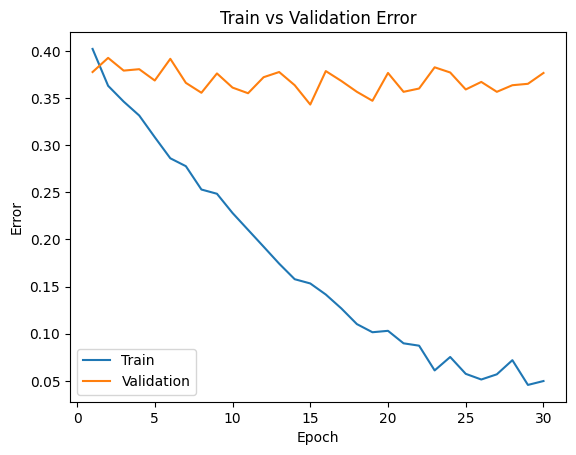

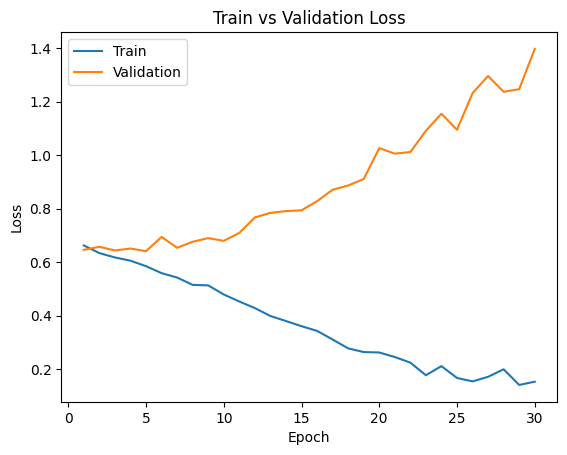

In [ ]:
ann_path = get_model_name("ANN", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(ann_path)

In [ ]:
ann = ANN()
train_net(ann, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.448, Train loss: 0.6837703734636307 |Validation err: 0.413, Validation loss: 0.6712464541196823
Epoch 2: Train err: 0.397375, Train loss: 0.6629869788885117 |Validation err: 0.406, Validation loss: 0.6591872870922089
Epoch 3: Train err: 0.3825, Train loss: 0.6505701690912247 |Validation err: 0.389, Validation loss: 0.6550218313932419
Epoch 4: Train err: 0.36875, Train loss: 0.6430697776377201 |Validation err: 0.3825, Validation loss: 0.650707557797432
Epoch 5: Train err: 0.358875, Train loss: 0.6355562768876553 |Validation err: 0.3785, Validation loss: 0.6479547917842865
Epoch 6: Train err: 0.35575, Train loss: 0.6305481307208538 |Validation err: 0.387, Validation loss: 0.6476765125989914
Epoch 7: Train err: 0.346125, Train loss: 0.6250808127224445 |Validation err: 0.384, Validation loss: 0.645769014954567
Epoch 8: Train err: 0.343, Train loss: 0.6184783428907394 |Validation err: 0.3815, V

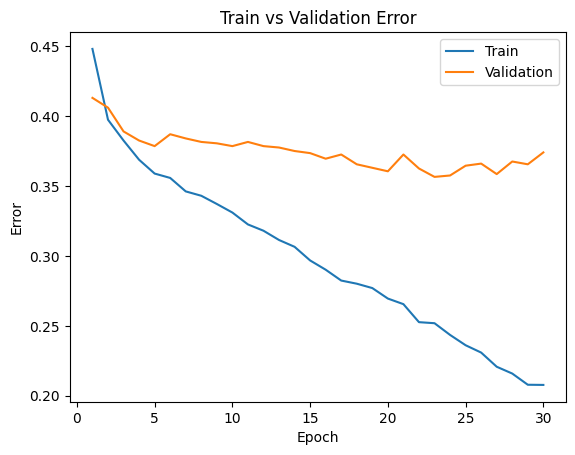

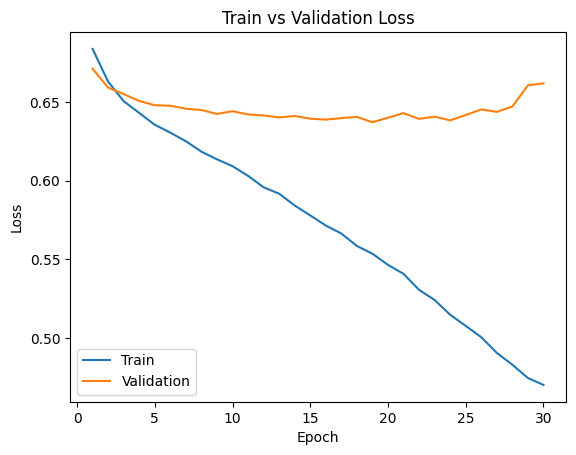

In [ ]:
ann_path = get_model_name("ANN", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(ann_path)

In [ ]:
ann = ANN()
train_net(ann, batch_size=256)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.425, Train loss: 0.6756256204098463 |Validation err: 0.3965, Validation loss: 0.6595589891076088
Epoch 2: Train err: 0.383625, Train loss: 0.6493016015738249 |Validation err: 0.3845, Validation loss: 0.6513916552066803
Epoch 3: Train err: 0.366, Train loss: 0.6365065649151802 |Validation err: 0.3825, Validation loss: 0.6477233543992043
Epoch 4: Train err: 0.3525, Train loss: 0.6259343307465315 |Validation err: 0.384, Validation loss: 0.6492223888635635
Epoch 5: Train err: 0.339625, Train loss: 0.6171437539160252 |Validation err: 0.377, Validation loss: 0.6423950791358948
Epoch 6: Train err: 0.331, Train loss: 0.6083634681999683 |Validation err: 0.3845, Validation loss: 0.6457751840353012
Epoch 7: Train err: 0.324, Train loss: 0.5987990312278271 |Validation err: 0.3785, Validation loss: 0.6429669857025146
Epoch 8: Train err: 0.31175, Train loss: 0.5882361251860857 |Validation err: 0.369, Va

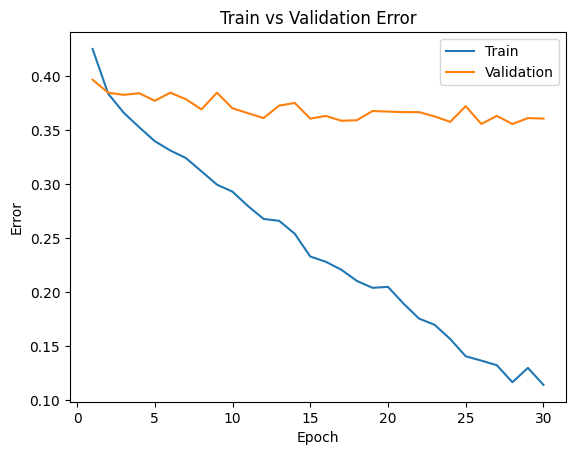

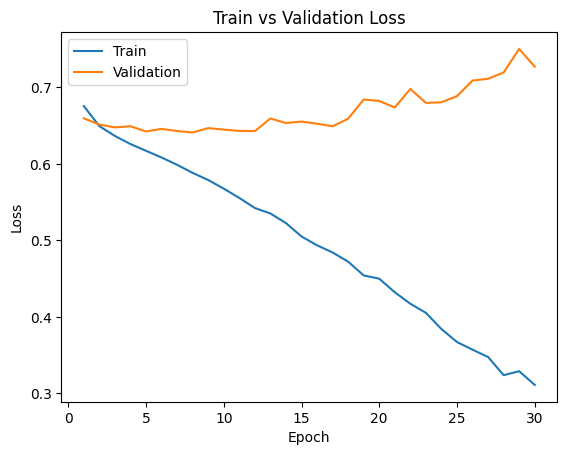

In [ ]:
ann_path = get_model_name("ANN", batch_size=256, learning_rate=0.01, epoch=29)
plot_training_curve(ann_path)

In [ ]:
#The best model is from Batch size = 512
#Epoch 24: Train err: 0.2435, Train loss: 0.5147828757762909 |Validation err: 0.3575, Validation loss: 0.6383553445339203

In [ ]:
ann_net = ANN()
model_path = get_model_name(ann_net.name, batch_size=512, learning_rate=0.01, epoch=23)
state = torch.load(model_path)
ann_net.load_state_dict(state)

<ipython-input-38-1214e49913de>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(ann_net, test_loader, criterion)
print(f"Prediction Error: {err}, BCE Error: {loss}")

Files already downloaded and verified
Files already downloaded and verified
Prediction Error: 0.346, BCE Error: 0.6320203319191933


The best CNN model is able to achieve

Prediction Error: 0.277, BCE Error: 0.5437365910038352

The best ANN model is able to achieve

Prediction Error: 0.346, BCE Error: 0.6320203319191933

Therefore, CNN performs better, as it has lower error.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab2_Cats_vs_Dogs.ipynb

[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 1913341 bytes to /content/Lab2_Cats_vs_Dogs.html
